In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler,RobustScaler,FunctionTransformer, QuantileTransformer)
# model fitting / evaluation / export
from sklearn.linear_model import (LogisticRegression,LinearRegression,Lasso,Ridge)
from sklearn.ensemble import (RandomForestClassifier,RandomForestRegressor,VotingClassifier)
from sklearn.neighbors import (KNeighborsClassifier,KNeighborsRegressor)
from sklearn.svm import (SVC, SVR,LinearSVC,LinearSVR)
from lightgbm import (LGBMClassifier,LGBMRegressor,plot_metric,plot_importance)
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (train_test_split,StratifiedKFold,KFold,cross_validate,RandomizedSearchCV,GridSearchCV)
from sklearn.metrics import (plot_confusion_matrix,classification_report,plot_roc_curve)
import pickle
from IPython.display import display_html

In [2]:
smart_grid_orig = pd.read_csv("uci_data.csv")

smart_grid_orig.head(3)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable


In [3]:
assert smart_grid_orig.isna().sum().sum() == 0, "some data missing"

stab_fine = max(smart_grid_orig.query("stabf == 'stable'")["stab"]) < 0
stabf_fine = min(smart_grid_orig.query("stabf == 'unstable'")["stab"]) > 0
assert (stab_fine & stabf_fine), "unexpected stab/stabf relationship"

print("As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.")

As expected, no missing data and `stab` values of less than 0 are labelled 'stable' in `stabf`.


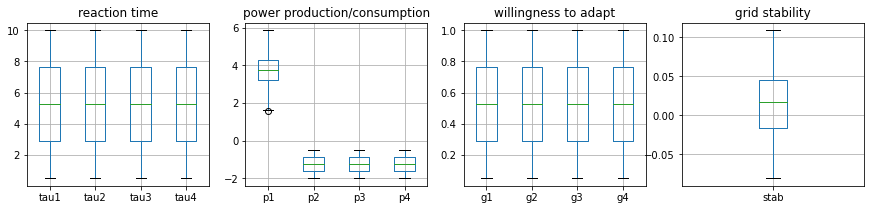

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for axs_ind, feature_group in enumerate(["tau", "p", "g"]):
    smart_grid_orig.boxplot(
        column=[feature_group + str(i + 1) for i in range(4)], 
        ax= axs[axs_ind]
    )
smart_grid_orig.boxplot(column="stab", ax= axs[3])

for axs_ind, title in enumerate(["reaction time", "power production/consumption",
                                 "willingness to adapt", "grid stability"]):
    axs[axs_ind].set(title=title);

In [5]:
print(smart_grid_orig["stabf"].value_counts(normalize=True))  # pretty balanced

unstable    0.638
stable      0.362
Name: stabf, dtype: float64


In [7]:
smart_grid = smart_grid_orig.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

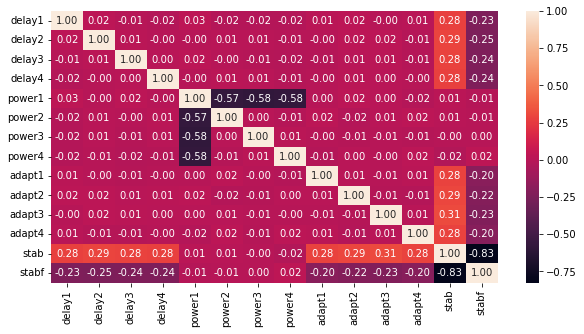

In [8]:
plt.figure(figsize = (10, 5))
sns.heatmap(smart_grid.corr(), fmt=".2f", annot=True);

In [9]:
X = smart_grid.drop(["stab", "stabf"], axis=1)
y = smart_grid[["stab", "stabf"]]

X_train_val_, X_test_, y_train_val, y_test = \
    train_test_split(X, y, test_size=0.2, stratify=y["stabf"], random_state=0)

# unsure about how X should be processed at the moment
X_train_val_w_pwr = X_train_val_.drop(["power1"], axis=1)
X_train_val_no_pwr = (X_train_val_
                      .drop(["power1", "power2", "power3", "power4"], axis=1))
# labels for both tasks
clf_y_train_val, clf_y_test = y_train_val["stabf"], y_test["stabf"]
reg_y_train_val, reg_y_test = y_train_val["stab"], y_test["stab"]

assert all(clf_y_train_val.value_counts(normalize=True) == \
    clf_y_test.value_counts(normalize=True)), \
    "inconsistent class share afer split"